In [1]:
#Chap4

In [15]:
import pymc as pm
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np

figsize(12.5, 4)

std_height = 15
mean_height = 150

# 地域の数
n_counties = 5000
pop_generator = pm.rdiscrete_uniform
norm = pm.rnormal

# 人口は一様分布から取得
population = pop_generator(100, 1500, size=n_counties)
print(population.size)

5000


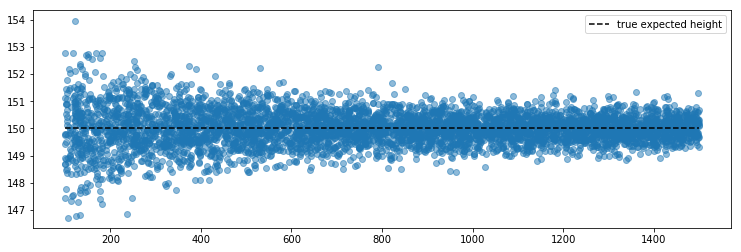

In [17]:
average_across_county = np.zeros(n_counties)
#地域ごとに正規分布からサンプリングして平均を取得
for i in range(n_counties):
    average_across_county[i] = norm(mean_height, 1./std_height**2, size=population[i]).mean()

# 平均の最大と最小を取得
i_min = np.argmin(average_across_county)
i_man = np.argmax(average_across_county)

plt.scatter(population, average_across_county, alpha=0.5)
plt.plot([100, 1500], [150, 150], color="k", ls="--", label="true expected height")
plt.legend()


In [22]:
# Kaggle
from os import makedirs
makedirs("data", exist_ok=True)
from urllib.request import urlretrieve

urlretrieve("https://git.io/vXtMv", "data/census_data.csv")

('data/census_data.csv', <http.client.HTTPMessage at 0x7f7e26411518>)

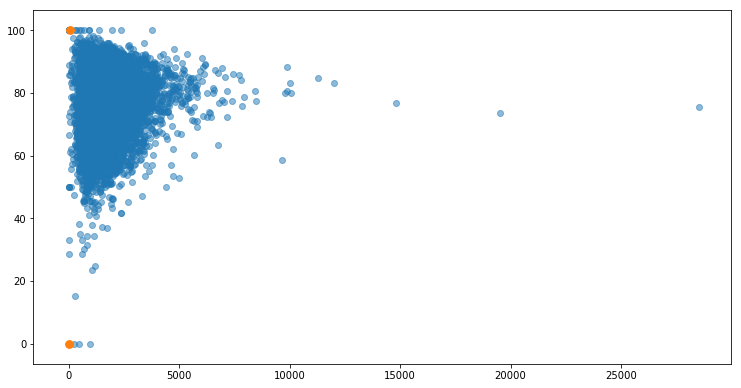

In [24]:
figsize(12.5, 6.5)
data = np.genfromtxt("data/census_data.csv", skip_header=1, delimiter=",")
plt.scatter(data[:, 1], data[:, 0], alpha=0.5)

i_min = np.argmin(data[:, 0])
i_max = np.argmax(data[:, 0])
plt.scatter([data[i_min, 1], data[i_max, 1]], [data[i_min, 0], data[i_max, 0]], s=60, marker="o", label="most extreme ponts")


In [27]:
# Reddit
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXtX2", "top_showerthoughts_submissions.py")

import praw

In [29]:
%run top_showerthoughts_submissions.py 2
print("Title of submission: ", top_post)

Title of submission:  Monopoly would be more realistic if you had to start on a board already owned and fully developed by the winner of the previous game. And you have to pay to roll the dice.


In [42]:
n_comments = len(contents)
print(n_comments)

# 適当に4つのコメントをピック
comments = np.random.randint(n_comments, size=4)
print("Some Comments (out of %d total) " % n_comments)
for i in comments:
    print("%s" % contents[i])
    print("upvotes/downvotes: %d/%d" % (votes[i][0], votes[i][1]))

98
Some Comments (out of 98 total) 
As a person who cleans daycare centers for a living, I can relate to how Anakin Skywalker feels about sand.
upvotes/downvotes: 64/3
Is there a low fructose corn syrup?
upvotes/downvotes: 42/11
Pockets are just bags we have sewn into our clothes.
upvotes/downvotes: 83/12
Killing and mutilating animals as a child is a sign of a future serial killer, but nobody bats an eye if they do it as a family bonding activity in camouflage.
upvotes/downvotes: 151/78


In [34]:
import pymc as pm

def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
    N = upvotes + downvotes
    upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
    observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
    map_ = pm.MAP([upvote_ratio, observations]).fit()
    mcmc = pm.MCMC([upvote_ratio, observations])
    mcmc.sample(samples, samples/4)
    return mcmc.trace("upvote_ratio")[:]

 [-----------------100%-----------------] 20000 of 20000 complete in 0.8 sec

/home/newton/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1855: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 20000 of 20000 complete in 0.7 sec

(0, 1)

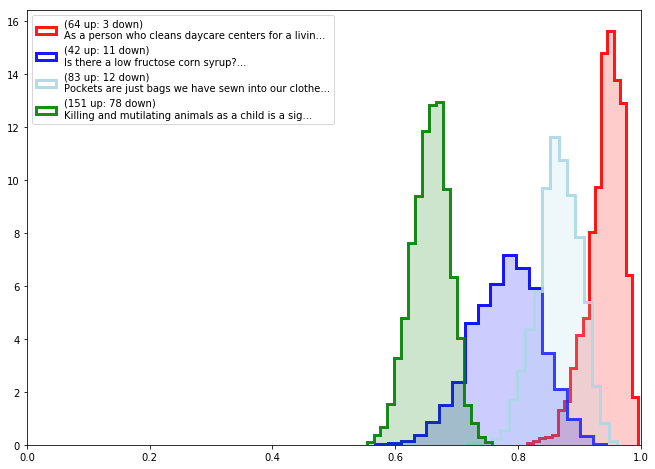

In [54]:
figsize(11., 8)
colors = ["red", "blue", "lightblue", "green"]

posteriors = []
for i in range(len(comments)):
    j = comments[i]
    label = '(%d up: %d down) \n%s...' % (votes[j, 0], votes[j, 1], contents[j][:50])
    posteriors.append(posterior_upvote_ratio(votes[j, 0], votes[j, 1]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=0.9, histtype="step", color=colors[i%5], lw=3, label=label)
    plt.hist(posteriors[i], bins=18, normed=True, alpha=0.2, histtype="stepfilled", color=colors[i], lw=3)

plt.legend(loc="upper left")
plt.xlim(0, 1)

[0 2 1 3] [0.88806602039706883, 0.68631443317019192, 0.80256062178830256, 0.60579354618308356]


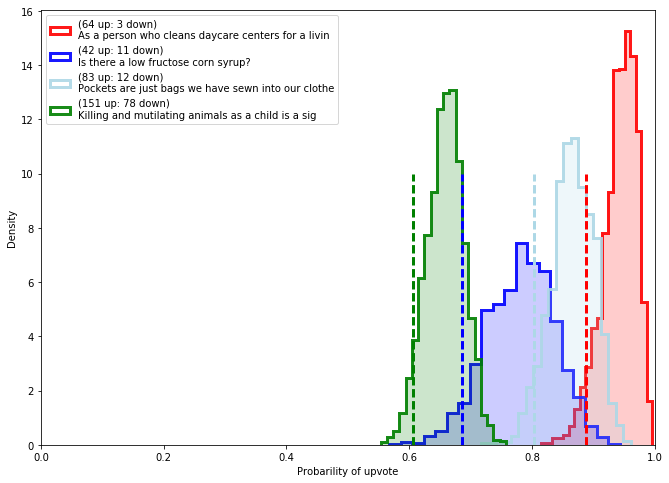

In [56]:
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(comments)):
    j = comments[i]

    label = '(%d up: %d down)\n%s' % (votes[j, 0], votes[j, 1], contents[j][:50])
    plt.hist(posteriors[i], bins=20, normed=True, alpha=.9, histtype="step", color=colors[i], lw=3, label=label)
    plt.hist(posteriors[i], bins=20, normed=True, alpha=.2, histtype="stepfilled", color=colors[i], lw=3)
    
    # 95%信用下限
    v = np.sort(posteriors[i])[int(0.05*N)]
    plt.vlines(v, 0, 10, color=colors[i], linestyles="--", linewidths=3)
    
    lower_limits.append(v)
    
plt.legend(loc="upper left")
plt.xlabel("Probarility of upvote")
plt.ylabel("Density")
plt.xlim(0, 1)

order = np.argsort(-np.array(lower_limits))
print(order, lower_limits)